In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import math, time
import matplotlib.pyplot as plt

# Data

In [2]:
data1 = pd.read_csv("..\data\AMD_Price.csv").set_index("Date")
data = pd.read_csv("..\data\DBA.csv").set_index("Date")

In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-03,20.500000,20.670000,20.450001,20.600000,19.699453,1837500
2023-05-04,20.500000,20.730000,20.500000,20.700001,19.795082,529400
2023-05-05,20.750000,21.070000,20.750000,21.030001,20.110657,290000
2023-05-08,21.030001,21.040001,20.889999,20.910000,19.995901,250500
2023-05-09,20.830000,20.990000,20.799999,20.959999,20.043715,634200


In [5]:
price = data.reset_index()[["Close"]]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [6]:
price

,Close
0,-0.934853
1,-0.902280
2,-0.794788
3,-0.833876
4,-0.817590
...,...
248,0.530944
249,0.381107
250,0.120521
251,-0.006514


In [7]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, look_back)

In [8]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# RNN

In [9]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        # Number of hidden layers
        self.num_layers = num_layers
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [11]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [12]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.03744984790682793
Epoch  20 MSE:  0.024424318224191666
Epoch  30 MSE:  0.022521745413541794
Epoch  40 MSE:  0.02113407477736473
Epoch  50 MSE:  0.016545750200748444
Epoch  60 MSE:  0.008571472018957138
Epoch  70 MSE:  0.005140518303960562
Epoch  80 MSE:  0.004864709917455912
Epoch  90 MSE:  0.004592543467879295


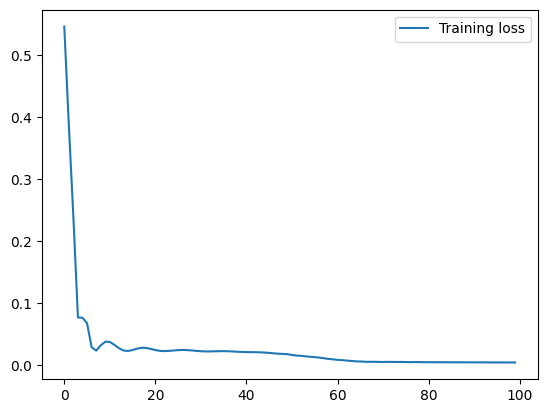

In [13]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [14]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.20 RMSE
Test Score: 1.67 RMSE


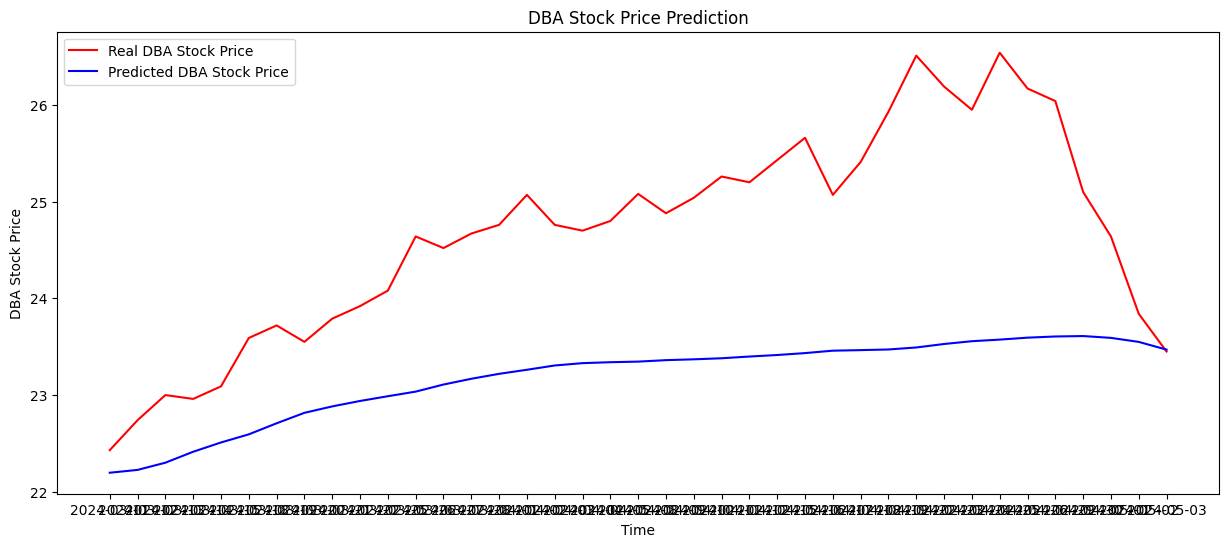

In [17]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(data[len(data)-len(y_test):].index, y_test, color = 'red', label = 'Real DBA Stock Price')
axes.plot(data[len(data)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted DBA Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('DBA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('DBA Stock Price')
plt.legend()
plt.savefig('dba_pred.png')
plt.show()

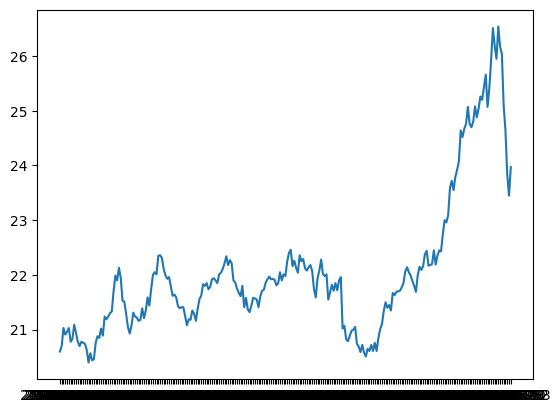

In [18]:
plt.plot(data["Close"])